In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, indices, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color='blue')
    else:
        plt.plot(train_s.index, train_s, label='Train', color='blue')
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True, 
                   input_shape=(X_train.shape[1], X_train.shape[2]))) 
    modelo.add(LSTM(60, 
                   activation='relu',
                   return_sequences=True)) 
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False)) 
    modelo.add(Dense(units=1))
    modelo.compile(optimizer='adam', loss='mean_squared_error')
    modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)
    
    return modelo
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse


In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_Tenerife = datos[datos['isla'] == 'TENERIFE']

datos_Tenerife = datos_Tenerife.set_index('fecha') # Asignamos la fecha como índice

In [4]:
# Variables globales a utilizar en todo el proceso

variables_covid = ['pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                            # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'Tenerife'         # Isla a la que se está realziando el estudio
fechas = datos_Tenerife.tail(dias_prediccion).index # Fechas de los días a predecir

In [5]:

# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_Tenerife_uni = datos_Tenerife[objetivo]
datos_Tenerife_uni_arr = np.array(datos_Tenerife_uni).reshape(-1, 1)

datos_Tenerife_mult_covid = datos_Tenerife[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
datos_Tenerife_mult_atm = datos_Tenerife[[objetivo, 'tmin', 'tmed', 'presMax']]
datos_Tenerife_mult_total = datos_Tenerife[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_uni_scaled = scaler.fit_transform(datos_Tenerife_uni_arr)

In [7]:
n_train = len(datos_Tenerife_uni_scaled) - dias_prediccion


train = datos_Tenerife_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_uni_scaled[n_train - dias_prediccion:len(datos_Tenerife_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 3s 81ms/step - loss: 0.0271 - val_loss: 0.0124
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0230 - val_loss: 0.0070
Epoch 3/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0204 - val_loss: 0.0043
Epoch 4/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0184 - val_loss: 0.0036
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0164 - val_loss: 0.0035
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0132 - val_loss: 0.0035
Epoch 7/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0095 - val_loss: 0.0034
Epoch 8/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.0037
Epoch 9/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0086 - val_loss: 0.0037
Epoch 10/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0086 - val_loss: 0.0041
Epoch 11/50
7/7 [============

In [10]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 376ms/step


In [11]:
y_pred

array([[747.598  ],
       [714.7977 ],
       [663.31494],
       [618.78754],
       [596.15076],
       [562.38196],
       [516.9757 ],
       [503.30106],
       [506.47882],
       [505.9247 ]], dtype=float32)

In [12]:
y_test

array([[269.],
       [193.],
       [636.],
       [760.],
       [716.],
       [607.],
       [636.],
       [266.],
       [163.],
       [319.]])

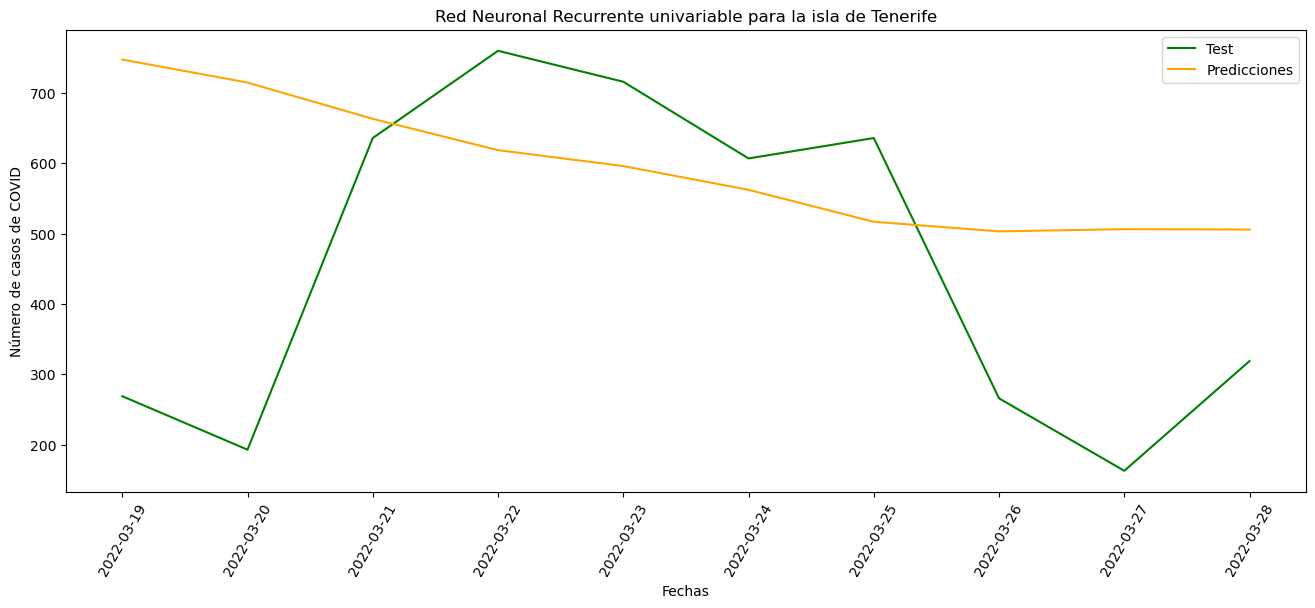

In [13]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

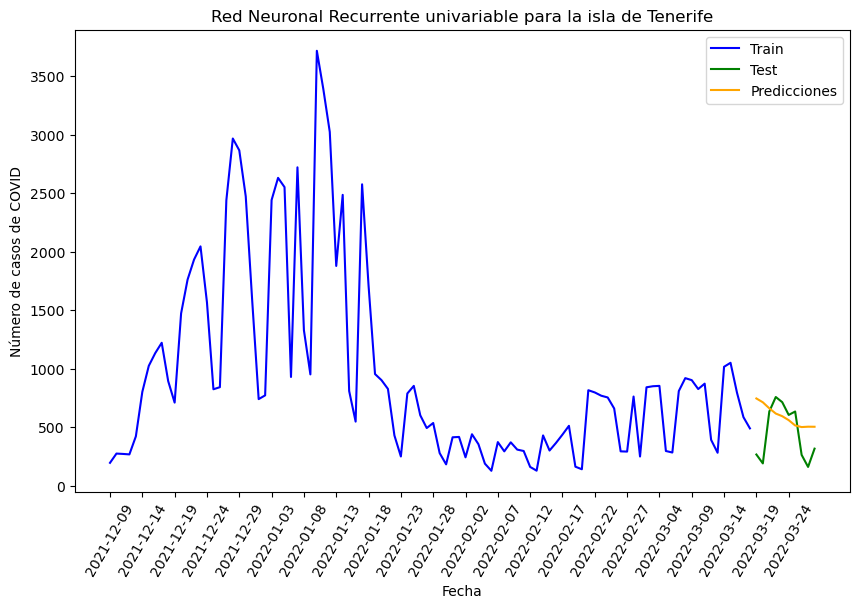

In [14]:
datos_train = datos_Tenerife_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit)

In [15]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 76176.77361411024
Error absoluto medio (MAE) del modelo: 222.01193237304688
Raíz del error cuadrático medio (RMSE) del modelo: 276.00140147127917


# Red Neuronal Recurrente multivariable con variables de pandemia

In [16]:
datos_Tenerife_mult_covid = datos_Tenerife[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled = scaler.fit_transform(datos_Tenerife_mult_covid)

In [17]:
# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_covid[objetivo]).reshape(-1, 1))

In [18]:
n_train = len(datos_Tenerife_mult_covid_scaled) - dias_prediccion


train = datos_Tenerife_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_covid_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_covid_scaled), :]

In [19]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [20]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 4s 75ms/step - loss: 0.0247 - val_loss: 0.0079
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0197 - val_loss: 0.0042
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0177 - val_loss: 0.0041
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0141 - val_loss: 0.0062
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0110 - val_loss: 0.0055
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 7/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0084 - val_loss: 0.0042
Epoch 8/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0084 - val_loss: 0.0037
Epoch 9/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0074 - val_loss: 0.0036
Epoch 10/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0072 - val_loss: 0.0036
Epoch 11/50
7/7 [============

In [21]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 420ms/step


In [22]:
y_pred

array([[ 644.59204],
       [ 682.4864 ],
       [ 828.8365 ],
       [1008.53406],
       [ 803.1597 ],
       [ 593.7909 ],
       [ 605.18756],
       [ 633.8489 ],
       [ 752.14594],
       [ 972.5461 ]], dtype=float32)

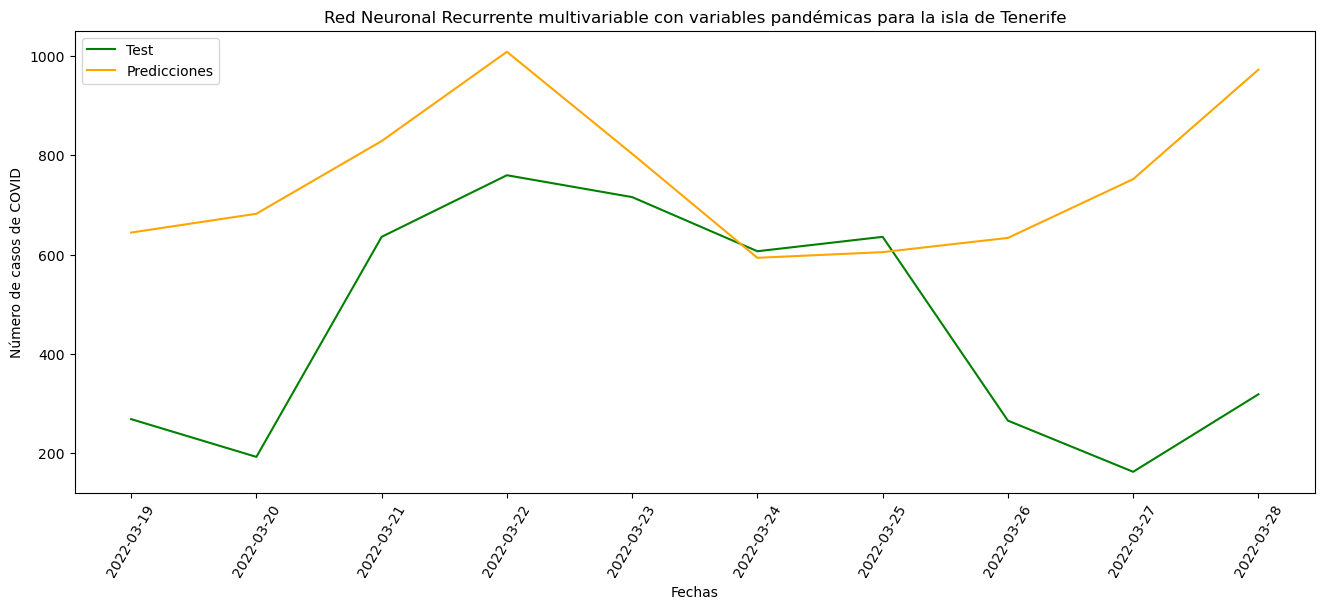

In [23]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

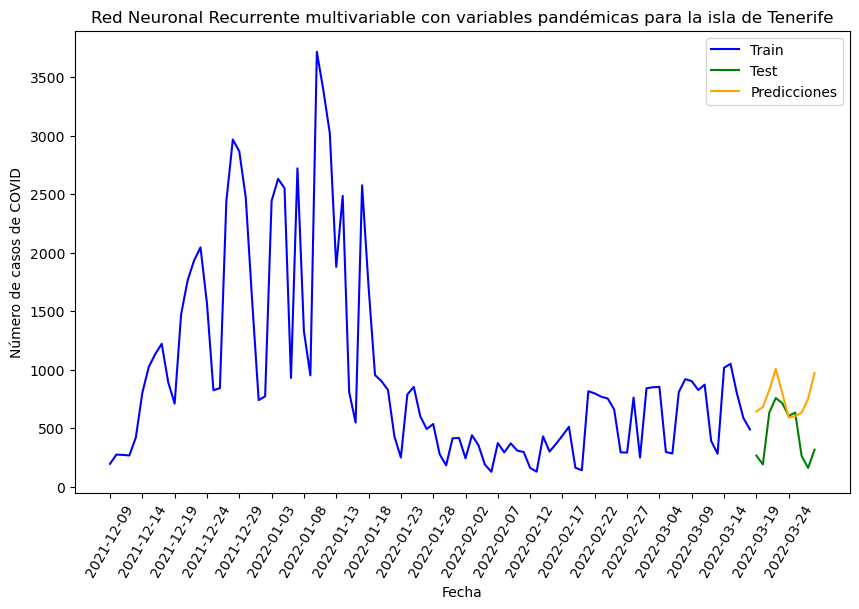

In [24]:
datos_train = datos_Tenerife_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [25]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 139787.03099106773
Error absoluto medio (MAE) del modelo: 304.8171142578125
Raíz del error cuadrático medio (RMSE) del modelo: 373.88103855513685


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled = scaler.fit_transform(datos_Tenerife_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_atm[objetivo]).reshape(-1, 1))

In [27]:
n_train = len(datos_Tenerife_mult_atm_scaled) - dias_prediccion


train = datos_Tenerife_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_atm_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_atm_scaled), :]

In [28]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [29]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 4s 72ms/step - loss: 0.0237 - val_loss: 0.0063
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0216 - val_loss: 0.0042
Epoch 3/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0193 - val_loss: 0.0041
Epoch 4/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0167 - val_loss: 0.0034
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0130 - val_loss: 0.0052
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0085 - val_loss: 0.0097
Epoch 7/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 8/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0084 - val_loss: 0.0035
Epoch 9/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0080 - val_loss: 0.0068
Epoch 10/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0078 - val_loss: 0.0116
Epoch 11/50
7/7 [============

In [30]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 368ms/step


In [31]:
y_pred

array([[744.3138 ],
       [658.053  ],
       [608.82855],
       [640.7425 ],
       [531.71155],
       [348.7454 ],
       [446.9445 ],
       [572.2841 ],
       [591.9237 ],
       [602.2211 ]], dtype=float32)

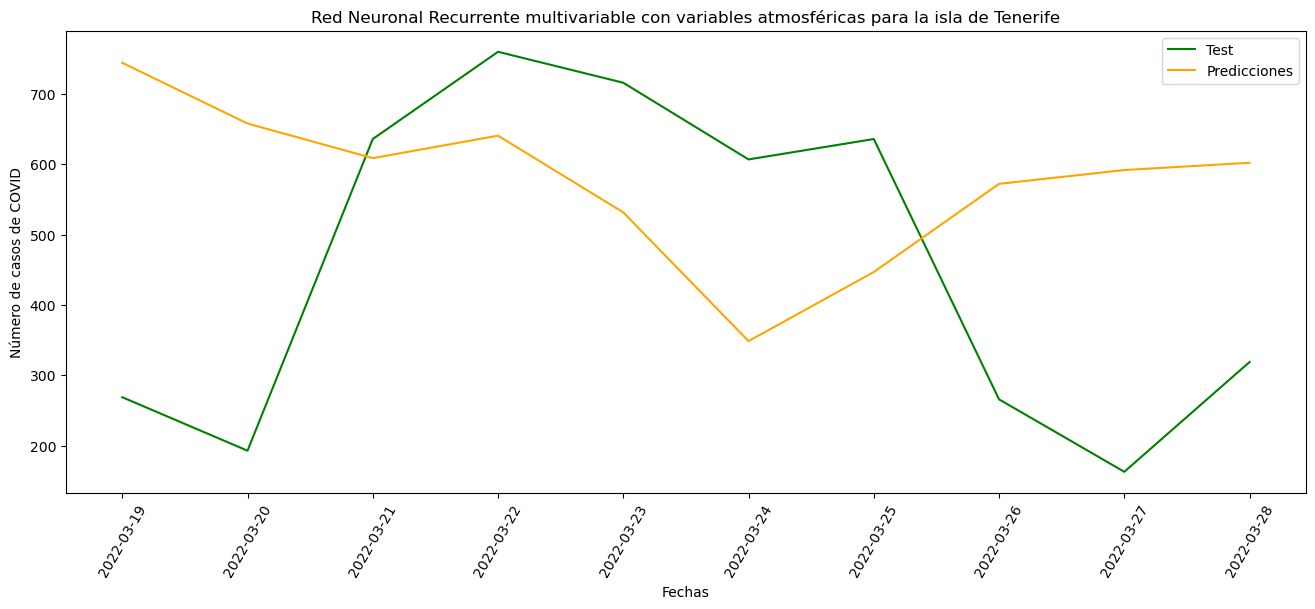

In [32]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

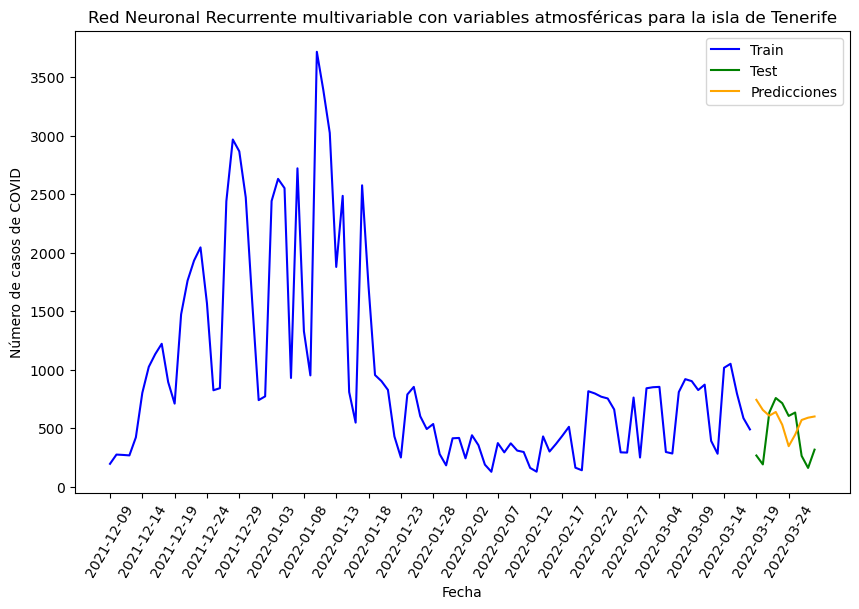

In [33]:
datos_train = datos_Tenerife_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [34]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 95155.74828529637
Error absoluto medio (MAE) del modelo: 273.68232421875
Raíz del error cuadrático medio (RMSE) del modelo: 308.47325376002436


# Red Neuronal Recurrente multivariable con todas las variables

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled = scaler.fit_transform(datos_Tenerife_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_total[objetivo]).reshape(-1, 1))

In [36]:
n_train = len(datos_Tenerife_mult_total_scaled) - dias_prediccion


train = datos_Tenerife_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_total_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_total_scaled), :]

In [37]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [38]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 4s 77ms/step - loss: 0.0227 - val_loss: 0.0036
Epoch 2/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0179 - val_loss: 0.0048
Epoch 3/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0137 - val_loss: 0.0034
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0095 - val_loss: 0.0033
Epoch 5/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0088 - val_loss: 0.0044
Epoch 6/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 7/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0075 - val_loss: 0.0057
Epoch 8/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0075 - val_loss: 0.0037
Epoch 9/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0070 - val_loss: 0.0037
Epoch 10/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 11/50
7/7 [============

In [39]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 467ms/step


In [40]:
y_pred

array([[363.40408],
       [381.6125 ],
       [438.5938 ],
       [453.99557],
       [355.57254],
       [292.78842],
       [274.46304],
       [261.45215],
       [288.82812],
       [377.1603 ]], dtype=float32)

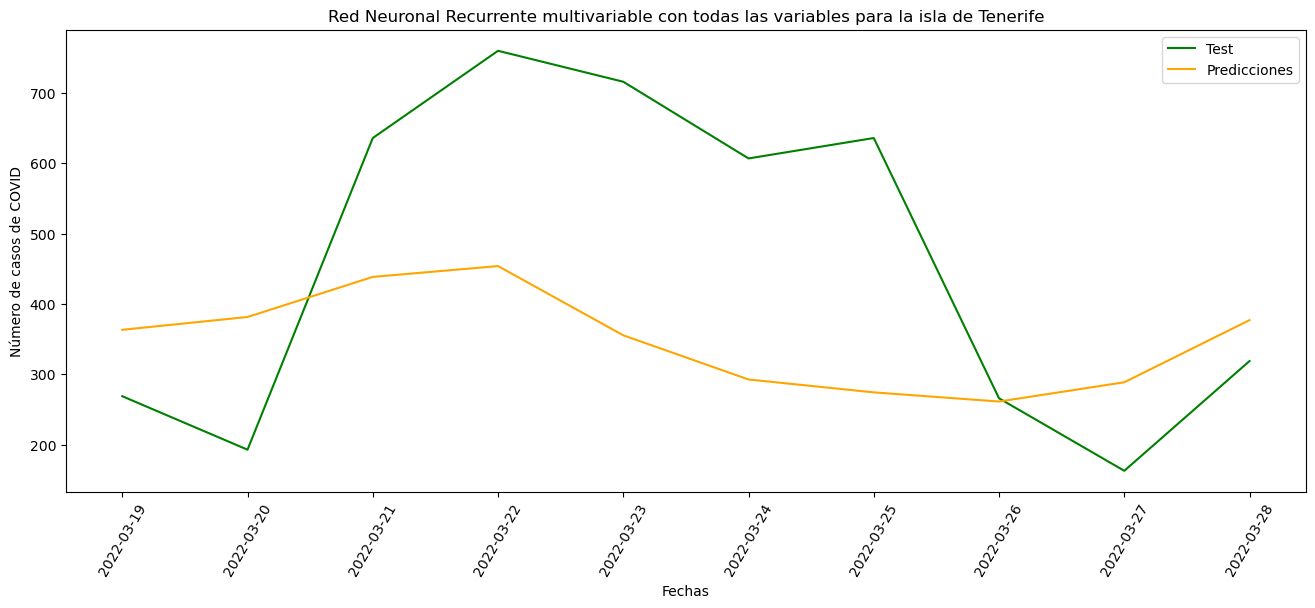

In [41]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

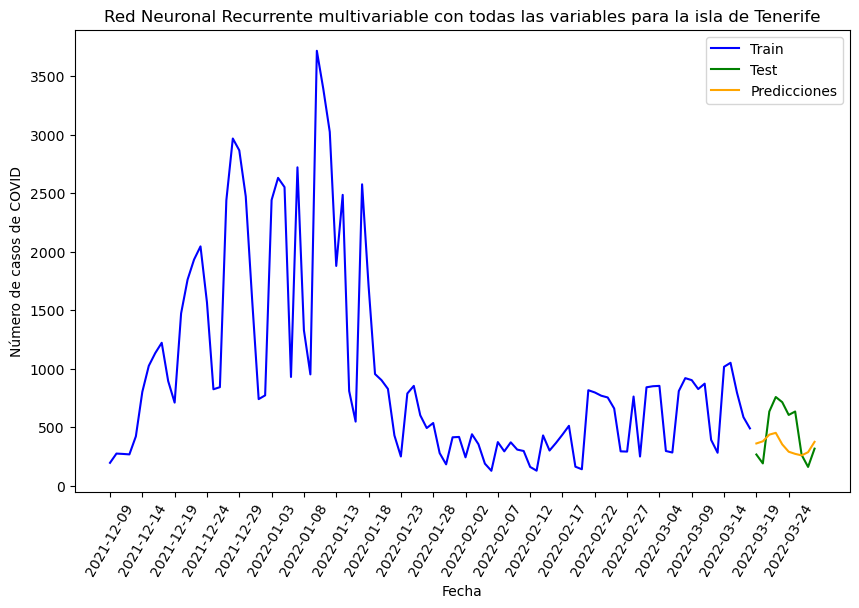

In [42]:
datos_train = datos_Tenerife_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [43]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 55567.657541816494
Error absoluto medio (MAE) del modelo: 201.11394653320312
Raíz del error cuadrático medio (RMSE) del modelo: 235.72793118724073
